<a href="https://colab.research.google.com/github/plawanrath/pytorch_basics/blob/main/pytorch_computervision101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
# training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

# testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

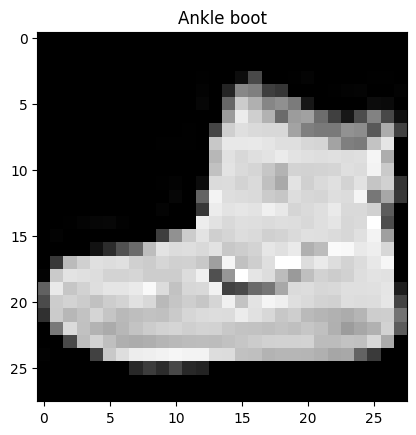

In [ ]:
image, label = training_data[0]
class_names = training_data.classes
print(f"Image shape: {image.shape}")
# matplot lib expects color channel last
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

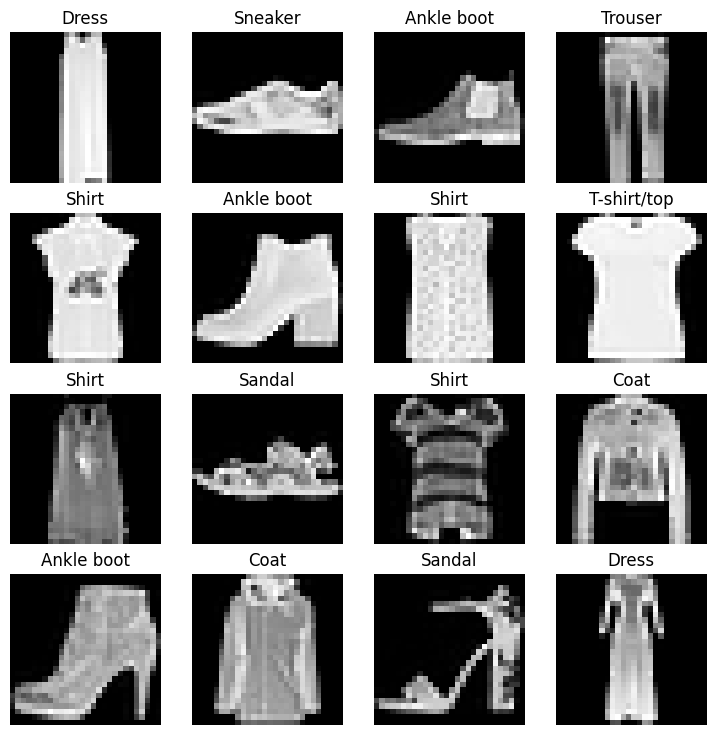

In [ ]:
torch.cuda.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(training_data), size=[1]).item()
  img, label = training_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
# Preparing DataLoader

from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

Image size: torch.Size([1, 28, 28])
Label: 8, Label size: torch.Size([])


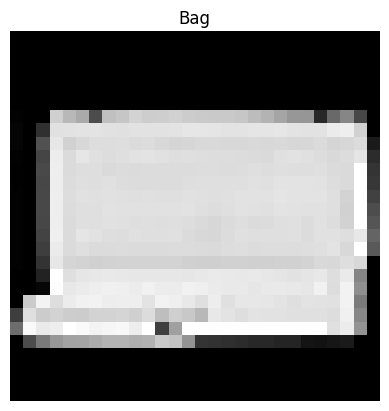

In [ ]:
training_features_batch, training_label_batch = next(iter(train_dataloader))
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random_idx = torch.randint(0, len(training_features_batch), size=[1]).item()
img, label = training_features_batch[random_idx], training_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, Label size: {label.shape}")

In [ ]:
# Flatten gives one value per vertor i.e. [color_channel, height, width] = [color_channel, height * width]
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import requests
from pathlib import Path

# Download helper function to plot decision boundary
if not Path("helper_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

# setup model with parameters
model0 = FashionMNISTModelV0(input_shape=(28*28), hidden_units=10, output_shape=len(class_names))

# Loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start, end, device=None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start = timer()

epochs = 10

# Create training and test loop

for epoch in tqdm(range(epochs)):
  # Training
  train_loss = 0 # calculate the avg training loss per batch
  for batch, (X, y) in enumerate(train_dataloader):
    model0.train()

    # forward pass
    y_pred = model0(X)

    # calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss 

    # optimizer
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # optimizer step
    optimizer.step()

    # Print
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
  
  # Get average loss
  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # forward pass
      test_pred = model0(X_test)

      # calculate loss
      test_loss += loss_fn(test_pred, y_test)

      # accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)
    # Calculate the average test acc
    test_acc /= len(test_dataloader)

  # Print
  print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate the training time
train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end, device=str(next(model0.parameters()).device)) 

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.6355 | Test Loss: 0.5312, Test acc: 80.7907
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4980 | Test Loss: 0.5618, Test acc: 80.5312
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4727 | Test Loss: 0.5687, Test acc: 81.1302
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4610 | Test Loss: 0.4846, Test acc: 82.8974
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Lo

In [ ]:
# make predictions and get model results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

def eval_model(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, acccuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += acccuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    
    # Scale the loss and acc to find average
    loss /= len(data_loader)
    acc /= len(data_loader)
  
  return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_acc": acc}

# calculate model results
model0_results = eval_model(model=model0, data_loader=test_dataloader, loss_fn=loss_fn, acccuracy_fn=accuracy_fn)
model0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47745034098625183,
 'model_acc': 83.2567891373802}

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU(),
    ) 
  
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model1 = FashionMNISTModelV1(input_shape=(28*28), hidden_units=10, output_shape=len(class_names))

# loss_fn
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [ ]:
def train_step(model, dataloader, loss_fn, accuracy_fn, optimizer):
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    model.train()

    # forward pass
    y_pred = model(X)

    # calculate loss and accuracy 
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

    # optimizer zero grad
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # optimizer step
    optimizer.step()

  # find average
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

In [ ]:
def test_step(model, dataloader, loss_fn, accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      # Forward pass
      test_pred = model(X)

      # calculate loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%\n")

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start = timer()

epochs = 10

# create optimization and evaluation loop
for epoch in tqdm(range(epochs)):
  train_step(model=model1, dataloader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer)
  test_step(model=model1, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

train_time_end = timer()
total_train_time_for_model1 = print_train_time(start=train_time_start, end=train_time_end)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.92836 | Train Acc: 66.64%
Test Loss: 0.71013 | Test Acc: 73.41254%

Train Loss: 0.58183 | Train Acc: 78.94%
Test Loss: 0.52224 | Test Acc: 81.71925%

Train Loss: 0.45577 | Train Acc: 83.53%
Test Loss: 0.48978 | Test Acc: 83.02716%

Train Loss: 0.43554 | Train Acc: 84.15%
Test Loss: 0.50202 | Test Acc: 81.95887%

Train Loss: 0.42174 | Train Acc: 84.74%
Test Loss: 0.45072 | Test Acc: 83.71605%

Train Loss: 0.41253 | Train Acc: 85.06%
Test Loss: 0.52475 | Test Acc: 81.07029%

Train Loss: 0.40797 | Train Acc: 85.13%
Test Loss: 0.43942 | Test Acc: 84.44489%

Train Loss: 0.40005 | Train Acc: 85.36%
Test Loss: 0.55052 | Test Acc: 80.91054%

Train Loss: 0.39794 | Train Acc: 85.36%
Test Loss: 0.42848 | Test Acc: 84.76438%

Train Loss: 0.39309 | Train Acc: 85.68%
Test Loss: 0.43611 | Test Acc: 84.45487%

Train time on None: 103.100 seconds


In [ ]:
model1_results = eval_model(model=model1, data_loader=test_dataloader, loss_fn=loss_fn, acccuracy_fn=accuracy_fn)
model1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4363010823726654,
 'model_acc': 84.47484025559105}

In [ ]:
model0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47745034098625183,
 'model_acc': 83.2567891373802}

In [ ]:
from torch.nn.modules.activation import ReLU
# Build a Convolutional Neural networks (CNN)
class FashionMNISTModelV2(nn.Module):
  """
  Example CNN model
  """
  def __init__(self, input_shape, hidden_units, output_shape) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape) # hidden units multiplier can be figure out by running without a multiplier and checking errors
        # We got this 7*7 by running nn.Linear(in_features=hidden_units, out_features=output_shape) and you will get Output of conv_block2: torch.Size([1, 10, 7, 7]) for conv_block2
        # This means that your in features for this layer needs to be the output of conv block2
    )
  
  def forward(self, x):
    x = self.conv_block1(x)
    # print(f"Output of conv_block1: {x.shape}")
    x = self.conv_block2(x)
    # print(f"Output of conv_block2: {x.shape}")
    return self.classifier(x)

In [ ]:
torch.manual_seed(42)

model2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
model2

FashionMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Recreate your model, pass dummy tensor and print chapes through each forward pass steps to check tensor output size. If you get an error you can check the matrix multiplication size to figure out
# what hidden_unit size you need
random_image_tensor = torch.randn(size=(1, 28, 28))
random_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
model2(random_image_tensor.unsqueeze(0))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [ ]:
# train and test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_model2 = timer()

# train and test model
epochs = 5

for epoch in tqdm(range(epochs)):
  train_step(model=model2, dataloader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer)
  test_step(model=model2, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

  train_time_end_model2 = timer()
  total_train_time_model2 = print_train_time(start=train_time_start_model2, end=train_time_end_model2)

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.42391 | Train Acc: 84.75%
Test Loss: 0.37629 | Test Acc: 86.62141%

Train time on None: 35.107 seconds
Train Loss: 0.34762 | Train Acc: 87.47%
Test Loss: 0.37196 | Test Acc: 86.95088%

Train time on None: 68.864 seconds
Train Loss: 0.32052 | Train Acc: 88.46%
Test Loss: 0.33466 | Test Acc: 87.98922%

Train time on None: 103.780 seconds
Train Loss: 0.30169 | Train Acc: 88.94%
Test Loss: 0.31158 | Test Acc: 88.59824%

Train time on None: 142.161 seconds
Train Loss: 0.28964 | Train Acc: 89.49%
Test Loss: 0.31035 | Test Acc: 88.55831%

Train time on None: 179.846 seconds


In [ ]:
model2_results = eval_model(model=model2, data_loader=test_dataloader, loss_fn=loss_fn, acccuracy_fn=accuracy_fn)
model2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31124159693717957,
 'model_acc': 88.52835463258786}

In [ ]:
# compare model results and training time
import pandas as pd
compare_results = pd.DataFrame([model0_results, model1_results, model2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.477450,83.256789
1,FashionMNISTModelV1,0.436301,84.474840
2,FashionMNISTModelV2,0.311242,88.528355


In [ ]:
# Add training time to results comparision
compare_results["training_time"] = [total_train_time, total_train_time_for_model1, total_train_time_model2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.477450,83.256789,103.127247
1,FashionMNISTModelV1,0.436301,84.474840,103.100124
2,FashionMNISTModelV2,0.311242,88.528355,179.845713


Text(0, 0.5, 'model')

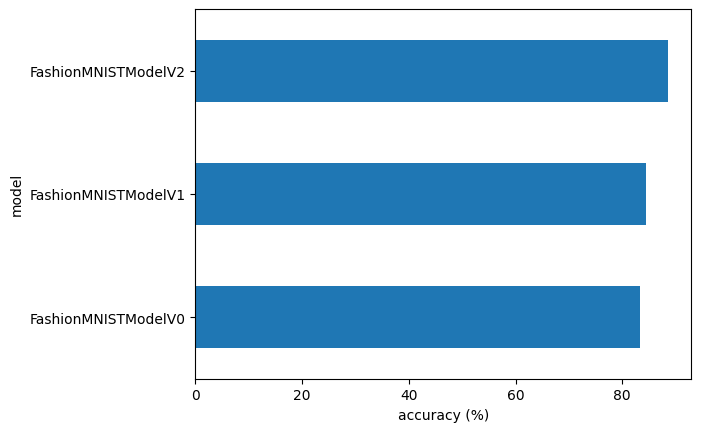

In [ ]:
# visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
# Make and evaluate random predictions

def make_predictions(model, data, device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)

      # forward pass
      pred_logits = model(sample)
      
      # prediction probability
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())
  
  return torch.stack(pred_probs)

In [ ]:
import random
# random.seed(42)
test_samples, test_labels = [], []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# make predictions
pred_probs = make_predictions(model=model2, data=test_samples, device="cuda")

# convert predictions to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 7, 2, 0, 1, 0, 3, 5, 4])

In [ ]:
test_labels

[9, 7, 2, 0, 1, 0, 4, 5, 4]

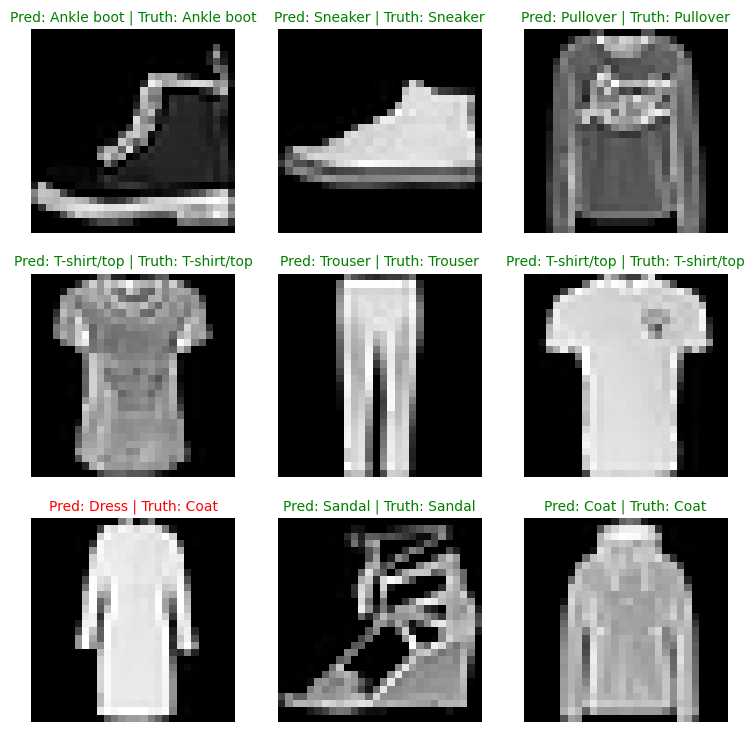

In [ ]:
# plot predictions
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  # create subplot
  plt.subplot(nrows, ncols, i+1)

  # plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  
  plt.axis(False)

In [ ]:
# Making prediction with trained model
y_preds = []
model2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # DO the forward pass
    y_logits = model2(X)
    # Turn predictions from logits to prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    # Put predictions to CPM
    y_preds.append(y_pred.cpu())
  
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:5]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([0, 5, 3, 7, 3])

In [ ]:
!pip install torchmetrics -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchmetrics-0.11.4-py3-none-any.whl (519 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import mlxtend
mlxtend.__version__

'0.22.0'

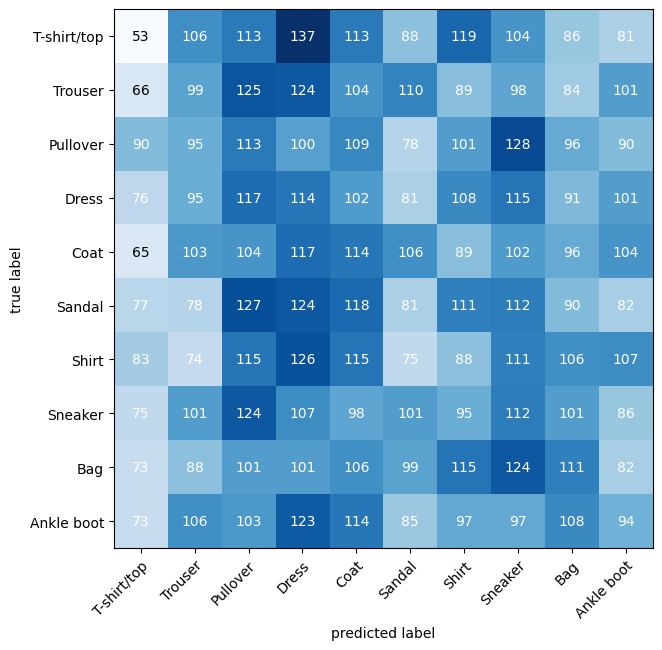

In [ ]:
# Use Confusion Matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plt the confusion matrix
fig, axis = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7),
)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create Model save
MODEL_NAME = "simple_comp_vision_cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save
torch.save(obj=model2.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
# load saved model
torch.cuda.manual_seed(42)

loaded_model2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))

# load
loaded_model2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model2

FashionMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31124159693717957,
 'model_acc': 88.52835463258786}

In [ ]:
# Evaluate the loaded model

torch.manual_seed(42)

loaded_model2_results = eval_model(
    loaded_model2,
    test_dataloader,
    loss_fn,
    accuracy_fn
)

loaded_model2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31041598320007324,
 'model_acc': 88.55830670926518}

In [ ]:
torch.isclose(torch.tensor(model2_results["model_loss"]), torch.tensor(loaded_model2_results["model_loss"]), atol=1e-02)

tensor(True)